In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool, cv
import matplotlib.pyplot as plt

# Load datasets
air_quality_df = pd.read_csv("data/datathon24_parte1/air_quality_gijon.csv")
meteo_df = pd.read_csv("data/datathon24_parte1/meteo_gijon.csv")
mobility_df = pd.read_csv("data/datathon24_parte1/movility_gijon.csv")
prediction_df = pd.read_csv("data/datathon24_parte2/prediction.csv")

# Merge datasets with the selected columns from air_quality_df
selected_columns = ["date", "SO2_GijonGlobal", "NO_GijonGlobal", "NO2_GijonGlobal", "CO_GijonGlobal", "PM10_GijonGlobal", "O3_GijonGlobal"]
filtered_air_quality_df = air_quality_df[selected_columns]
merged_df = filtered_air_quality_df.merge(meteo_df, on="date", how='outer').merge(mobility_df, on="date", how='outer').merge(prediction_df, on="date", how='outer')

# Convert 'date' to datetime, sort, and handle missing values
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df.sort_values('date', inplace=True)
merged_df.ffill(inplace=True)
merged_df.bfill(inplace=True)

# Normalize features and reintroduce cyclical features before normalization
scaler = StandardScaler()
exclude_cols = ["date", "ICA_PM25_target"]
features_to_scale = [col for col in merged_df.columns if col not in exclude_cols]
merged_df[features_to_scale] = scaler.fit_transform(merged_df[features_to_scale])

# Preparing x_final_prediction for December 2023
x_final_prediction_with_date = merged_df[
    (merged_df["date"] >= "2023-12-01") & (merged_df["date"] <= "2023-12-31")
]

# Ensure features are prepared similarly to the training data
x_final_prediction = x_final_prediction_with_date.drop(columns=['date', 'ICA_PM25_target'])

# Apply the same scaler transformation to x_final_prediction
x_final_prediction[features_to_scale] = scaler.transform(x_final_prediction[features_to_scale])

C:\Users\Daniel\AppData\Local\Temp\ipykernel_19548\501399822.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
0:	total: 164ms	remaining: 2m 43s
200:	total: 3.98s	remaining: 15.8s
400:	total: 7.74s	remaining: 11.6s
600:	total: 11.6s	remaining: 7.69s
800:	total: 15.7s	remaining: 3.91s
999:	total: 19.7s	remaining: 0us
Best parameters: {'depth': 8, 'iterations': 1000, 'learning_rate': 0.01}
Best AUC: 0.8690656565656565
Accuracy on test set: 0.855191256830601
AUC on test set: 0.8787212787212786


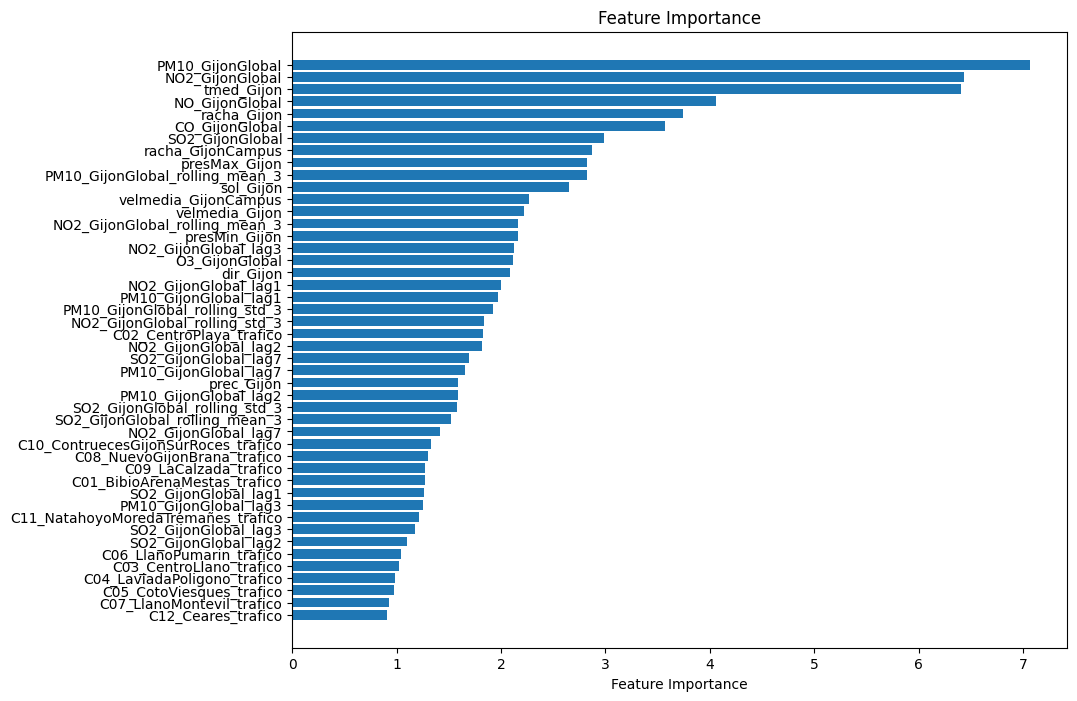

0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_auc_score, accuracy_score

# Improved Feature Engineering
def enhanced_feature_engineering(df):
    # Adding more lag features for PM10 and statistical features
    for pollutant in ['PM10_GijonGlobal', 'NO2_GijonGlobal', 'SO2_GijonGlobal']:
        for lag in [1, 2, 3, 7]:
            df[f'{pollutant}_lag{lag}'] = df[pollutant].shift(lag)
        df[f'{pollutant}_rolling_mean_3'] = df[pollutant].rolling(window=3).mean()
        df[f'{pollutant}_rolling_std_3'] = df[pollutant].rolling(window=3).std()
    df.fillna(method='bfill', inplace=True)
    return df

merged_df = enhanced_feature_engineering(merged_df)

X = merged_df.drop(['date', 'ICA_PM25_target'], axis=1)
y = merged_df['ICA_PM25_target']

# Split and scale the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize CatBoostClassifier
model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', verbose=200)

# Define the parameter grid
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=3)
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and scores
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best AUC: {grid_search.best_score_}")

# Use the best estimator for further predictions
best_model = grid_search.best_estimator_

# Evaluation on the test set
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("AUC on test set:", roc_auc_score(y_test, y_pred_proba))

# Feature importance visualization
feature_importances = best_model.get_feature_importance()
plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(feature_importances)), sorted(feature_importances))
plt.yticks(np.arange(len(X.columns)), X.columns[np.argsort(feature_importances)])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

In [5]:
# Prepare for final predictions
x_final_scaled = scaler.transform(merged_df[merged_df['date'] >= '2023-12-01'].drop(['date', 'ICA_PM25_target'], axis=1))
final_predictions = best_model.predict(x_final_scaled)

# Convert predictions to integers
final_predictions_int = final_predictions.astype(int)

# Convert integer predictions into a comma-separated string
predictions_string = ','.join(map(str, final_predictions_int))
print(predictions_string)


0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
